In [92]:
from pydrake.all import FindResourceOrThrow, StartMeshcat, MeshcatVisualizer
meshcat = StartMeshcat()


INFO:drake:Meshcat listening for connections at http://localhost:7002


In [116]:
# %tb

import importlib
import traj_optim
import fsm_utils

importlib.reload(traj_optim)
importlib.reload(fsm_utils)
from traj_optim import TrajectoryOptimizationSolution, read_csv
from fsm_utils import (
    LEFT_STANCE, RIGHT_STANCE, SPACE_STANCE, DOUBLE_SUPPORT
)

# N = 5
# initial_state = np.zeros(4)
# final_configuration = np.array([np.pi, 0])
# tf = 3.0
# distance = 15.0
# x_traj, u_traj, prog, _, _ = find_throwing_trajectory(N, initial_state, final_configuration, distance, tf)

# Walking

# Blue is Right feet, Red is left

solver = TrajectoryOptimizationSolution()
N = 10
mode_seqs = [RIGHT_STANCE] #, LEFT_STANCE, RIGHT_STANCE]
repeat = 1
initial_states = read_csv("q&v.csv", N * repeat * len(mode_seqs))
tf = 0.2 # just now is tf = 2
destination = 0.5

x_traj, u_traj, prog = solver.solve(N, mode_seqs, repeat, initial_states, tf, destination, iters=4e3)

Whole x shape:  (1, 10, 14)
Destination: 0.5m
mu = 1
Testing  4000.0  iterations
Time taken: 10.666586333012674 seconds
optimal cost:  0.0
x_sol:  [[[ 6.62402320e-14  8.00000000e-01  1.03201795e-13 -6.43501110e-01
    1.28700222e+00 -6.43501110e-01  1.28700222e+00  1.27965284e-13
   -1.17331939e-13 -4.81274427e-15  2.08283973e-14  1.70794374e-14
    1.49162186e-13 -2.58677916e-16]
  [ 2.56407556e-02  9.25979108e-01  2.61917741e-02 -1.00214402e+00
    1.73842218e+00 -3.26754410e-01  7.71691535e-01 -8.76274134e-08
   -3.71608477e-07  1.04867871e-02 -2.08796062e+01  2.78608738e+01
    1.04857112e-02  1.98909564e-06]
  [ 1.82324258e-01  7.79205976e-01  1.50196378e-01 -1.30050189e+00
    2.32678574e+00 -6.42804254e-01  1.33495679e+00 -6.54354785e-07
   -4.32909872e-08 -7.74698163e-02 -6.68766021e+00  1.96007366e+01
   -7.74705869e-02 -1.25949925e-07]
  [ 2.13538997e-01  8.26949718e-01  1.86140902e-01 -1.41538455e+00
    2.42373673e+00 -5.78851619e-01  1.13448183e+00 -1.28504456e-07
    5.60

## Visualization

RuntimeError: Exception while evaluating SNOPT costs and constraints: 'KeyboardInterrupt: <EMPTY MESSAGE>

At:
  /Users/mac/Downloads/Final/traj_optim.py(158): EvaluateDynamics
  /Users/mac/Downloads/Final/traj_optim.py(193): CollocationConstraintEvaluator
  /Users/mac/Downloads/Final/traj_optim.py(214): CollocationConstraintHelper
  /Users/mac/Downloads/Final/traj_optim.py(528): solve
  /var/folders/2b/f05brwcd04j_z8kby3z17scw0000gn/T/ipykernel_94757/1426465502.py(33): <module>
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3550): run_code
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3490): run_ast_nodes
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3308): run_cell_async
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/IPython/core/async_helpers.py(129): _pseudo_sync_runner
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3103): _run_cell
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py(3048): run_cell
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/ipykernel/zmqshell.py(549): run_cell
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/ipykernel/ipkernel.py(429): do_execute
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(766): execute_request
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(424): dispatch_shell
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(518): process_one
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/ipykernel/kernelbase.py(529): dispatch_queue
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/events.py(80): _run
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py(1922): _run_once
  /opt/homebrew/Cellar/python@3.11/3.11.6_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/asyncio/base_events.py(607): run_forever
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py(205): start
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py(739): start
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/traitlets/config/application.py(1077): launch_instance
  /Users/mac/Downloads/Final/.venv/lib/python3.11/site-packages/ipykernel_launcher.py(17): <module>
  <frozen runpy>(88): _run_code
  <frozen runpy>(198): _run_module_as_main
'

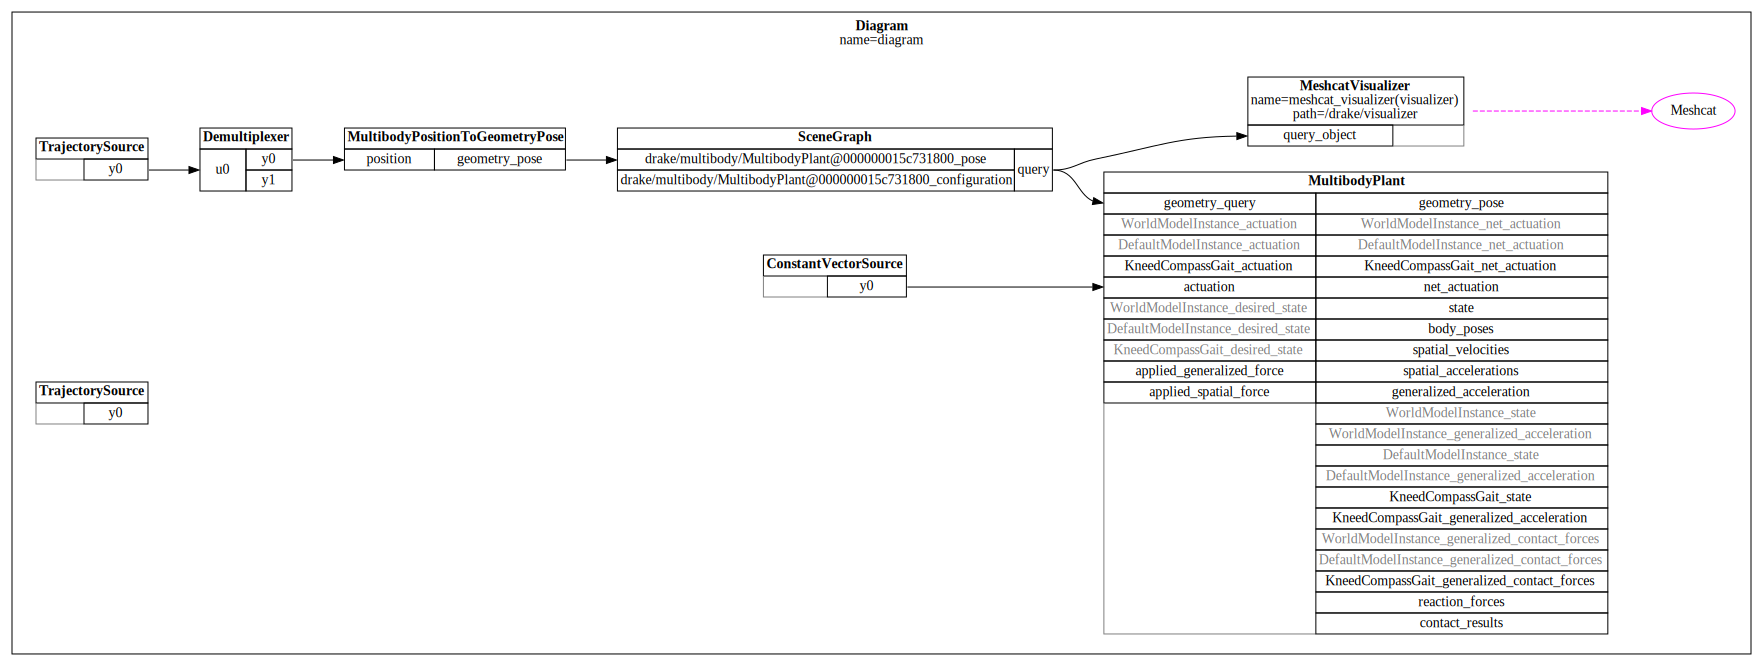

In [117]:
%tb
import matplotlib.pyplot as plt
import numpy as np
import time
from pydrake.math import RigidTransform
import pydot
from IPython.display import SVG, display


from pydrake.all import (
    DiagramBuilder, Simulator, FindResourceOrThrow, MultibodyPlant, PiecewisePolynomial, SceneGraph,
    Parser, MultibodyPositionToGeometryPose, TrajectorySource, Demultiplexer, ConstantVectorSource,
    AddMultibodyPlantSceneGraph, HalfSpace, CoulombFriction
)



# Create a MultibodyPlant for the arm
file_name = "planar_walker.urdf"
builder = DiagramBuilder()
scene_graph = builder.AddSystem(SceneGraph())
plant = builder.AddSystem(MultibodyPlant(0.0))
#plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.05)
plant.RegisterAsSourceForSceneGraph(scene_graph)
Parser(plant=plant).AddModels(file_name)

plant.WeldFrames(
            plant.world_frame(),
            plant.GetBodyByName("base").body_frame(),
            RigidTransform.Identity()
        )

plant.Finalize()
"""

builder = DiagramBuilder()

# Add a planar walker to the simulation
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 0.05)
#plant, scene_graph = AddMultibodyPlantSceneGraph(builder, 10)

X_WG = HalfSpace.MakePose(np.array([0,0, 1]), np.zeros(3,))
plant.RegisterCollisionGeometry(
    plant.world_body(), 
    X_WG, HalfSpace(), 
    "collision", 
    CoulombFriction(1.0, 1.0)
)
parser = Parser(plant)
parser.AddModels("planar_walker.urdf")
plant.WeldFrames(
    plant.world_frame(),
    plant.GetBodyByName("base").body_frame(),
    RigidTransform.Identity()
)
plant.Finalize()
"""


n_q = plant.num_positions()
n_v = plant.num_velocities()
n_u = plant.num_actuators()

x_traj_source = builder.AddSystem(TrajectorySource(x_traj))
u_traj_source = builder.AddSystem(TrajectorySource(u_traj))

demux = builder.AddSystem(Demultiplexer(np.array([n_q, n_v])))
to_pose = builder.AddSystem(MultibodyPositionToGeometryPose(plant))
zero_inputs = builder.AddSystem(ConstantVectorSource(np.zeros(n_u)))

builder.Connect(zero_inputs.get_output_port(), plant.get_actuation_input_port())
builder.Connect(x_traj_source.get_output_port(), demux.get_input_port())
builder.Connect(demux.get_output_port(0), to_pose.get_input_port())
builder.Connect(to_pose.get_output_port(), scene_graph.get_source_pose_port(plant.get_source_id()))
builder.Connect(scene_graph.get_query_output_port(), plant.get_geometry_query_input_port())


MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)

diagram = builder.Build()
diagram.set_name("diagram")

display(SVG(pydot.graph_from_dot_data(
    diagram.GetGraphvizString(max_depth=2))[0].create_svg()))


# Visualize the motion for `n_playback` times
# n_playback = 3
# for i in range(n_playback):
#   # Set up a simulator to run this diagram.
simulator = Simulator(diagram)
simulator.Initialize()
simulator.set_target_realtime_rate(0.05)
simulator.AdvanceTo(tf);
time.sleep(2)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ef2d9453-73df-41fc-adfb-4330c09008c0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>